In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install opencv-python ultralytics

In [4]:
!pip install opencv-python-headless

In [5]:
import os
import time
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO  # Replace with actual import paths
from tracker import Tracker


In [6]:
video_folder = '/content/drive/MyDrive/TrafficDataset/video'
result_folder = '/content/drive/MyDrive/TrafficResult1'
os.makedirs(result_folder, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Streaming output truncated to the last 5000 lines.
0: 640x448 4 cars, 2 trucks, 1 clock, 23.7ms
Speed: 2.1ms preprocess, 23.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 (no detections), 11.9ms
Speed: 2.1ms preprocess, 11.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 5 cars, 2 trucks, 1 clock, 22.3ms
Speed: 2.1ms preprocess, 22.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 car, 9.6ms
Speed: 2.1ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 2 cars, 1 truck, 23.0ms
Speed: 1.9ms preprocess, 23.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 (no detections), 10.6ms
Speed: 2.3ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 7 cars, 1 truck, 36.9ms
Speed: 2.3ms preprocess, 36.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448

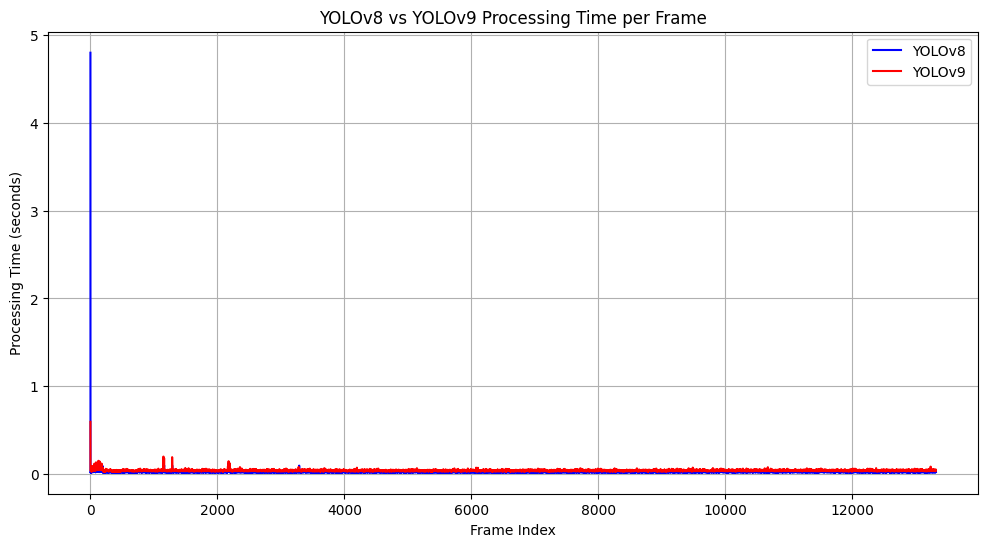

Frames processed with YOLOv8: 13317
Frames processed with YOLOv9: 13317


In [7]:
def process_video(video_path, yolov8_model, yolov9_model):
    """Processes a video with both YOLOv8 and YOLOv9, collecting processing times."""
    cap = cv2.VideoCapture(video_path)
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    output_video_path = os.path.join(result_folder, f'{video_name}_comparison_result.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))
    down = {}
    counter_down = set()
    yolov8_processing_times = []
    yolov9_processing_times = []

    try:
        tracker = Tracker()
        class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            combined_frame = frame.copy()

            # Process with YOLOv8 (left side)
            start_time_yolov8 = time.time()
            results_yolov8 = yolov8_model(frame[:, :frame.shape[1] // 2])
            boxes_yolov8 = results_yolov8[0].boxes.data.cpu().numpy()
            stop_time_yolov8 = time.time() - start_time_yolov8
            yolov8_processing_times.append(stop_time_yolov8)

            bbox_list_yolov8 = []
            for box in boxes_yolov8:
                x1, y1, x2, y2, _, class_id = box
                if int(class_id) < len(class_list) and class_list[int(class_id)] == 'car':
                    bbox_list_yolov8.append([int(x1), int(y1), int(x2), int(y2)])

            bbox_id_yolov8 = tracker.update(bbox_list_yolov8)
            for bbox in bbox_id_yolov8:
                x3, y3, x4, y4, id = bbox
                cx = (x3 + x4) // 2
                cy = (y3 + y4) // 2

                cv2.circle(combined_frame[:, :frame.shape[1] // 2], (cx, cy), 4, (0, 255, 0), -1)
                cv2.putText(combined_frame[:, :frame.shape[1] // 2], str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)
                cv2.putText(combined_frame[:, :frame.shape[1] // 2], f'YOLOv8', (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)
                cv2.putText(combined_frame[:, :frame.shape[1] // 2], f'Time: {stop_time_yolov8:.2f}s', (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2, cv2.LINE_AA)

            # Process with YOLOv9 (right side)
            start_time_yolov9 = time.time()
            results_yolov9 = yolov9_model(frame[:, frame.shape[1] // 2:])
            boxes_yolov9 = results_yolov9[0].boxes.data.cpu().numpy()
            stop_time_yolov9 = time.time() - start_time_yolov9
            yolov9_processing_times.append(stop_time_yolov9)

            bbox_list_yolov9 = []
            for box in boxes_yolov9:
                x1, y1, x2, y2, _, class_id = box
                if int(class_id) < len(class_list) and class_list[int(class_id)] == 'car':
                    bbox_list_yolov9.append([int(x1) + frame.shape[1] // 2, int(y1), int(x2) + frame.shape[1] // 2, int(y2)])

            bbox_id_yolov9 = tracker.update(bbox_list_yolov9)
            for bbox in bbox_id_yolov9:
                x3, y3, x4, y4, id = bbox
                cx = (x3 + x4) // 2
                cy = (y3 + y4) // 2

                cv2.circle(combined_frame[:, frame.shape[1] // 2:], (cx, cy), 4, (0, 0, 255), -1)
                cv2.putText(combined_frame[:, frame.shape[1] // 2:], str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.putText(combined_frame[:, frame.shape[1] // 2:], f'YOLOv9', (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.putText(combined_frame[:, frame.shape[1] // 2:], f'Time: {stop_time_yolov9:.2f}s', (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2, cv2.LINE_AA)

            # Draw red line and car count (combined)
            red_color = (0, 0, 255)
            cv2.line(combined_frame, (282, 308), (1004, 308), red_color, 3)
            cv2.putText(combined_frame, 'red line', (280, 308), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            downwards = len(counter_down)
            cv2.putText(combined_frame, f'going down - {downwards}', (60, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1, cv2.LINE_AA)

            for bbox_id in bbox_id_yolov8:
                x3, y3, x4, y4, id = bbox_id
                if y3 > 308 and id not in counter_down:
                    down[id] = y3
                    counter_down.add(id)
            for bbox_id in bbox_id_yolov9:
                x3, y3, x4, y4, id = bbox_id
                if y3 > 308 + frame.shape[1] // 2 and id not in counter_down:
                    down[id] = y3
                    counter_down.add(id)

            out.write(combined_frame)

    except Exception as e:
        print(f"Error processing video '{video_path}': {e}")
        raise

    cap.release()
    out.release()

    return yolov8_processing_times, yolov9_processing_times

if __name__ == '__main__':
    video_folder = '/content/drive/MyDrive/TrafficDataset/video'
    result_folder = '/content/drive/MyDrive/TrafficResult1'

    if not os.path.exists(result_folder):
        os.makedirs(result_folder)

    yolov8_model = YOLO('yolov8n.pt')
    yolov9_model = YOLO('yolov9c.pt')

    video_files = os.listdir(video_folder)
    all_yolov8_times = []
    all_yolov9_times = []

    for video_file in video_files:
        video_path = os.path.join(video_folder, video_file)
        yolov8_times, yolov9_times = process_video(video_path, yolov8_model, yolov9_model)

        # Collect processing times
        all_yolov8_times.extend(yolov8_times)
        all_yolov9_times.extend(yolov9_times)

    # Optional: Generate performance graph (requires matplotlib)
    try:
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 6))
        plt.plot(all_yolov8_times, label='YOLOv8', color='blue')
        plt.plot(all_yolov9_times, label='YOLOv9', color='red')
        plt.xlabel('Frame Index')
        plt.ylabel('Processing Time (seconds)')
        plt.title('YOLOv8 vs YOLOv9 Processing Time per Frame')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(result_folder, 'performance_comparison.png'))
        plt.show()
    except ImportError as e:
        print("matplotlib is not installed, skipping the performance graph generation.")
    except Exception as e:
        print(f"Error generating performance graph: {e}")

    print(f"Frames processed with YOLOv8: {len(all_yolov8_times)}")
    print(f"Frames processed with YOLOv9: {len(all_yolov9_times)}")

# Destroy all windows
cv2.destroyAllWindows()


In [8]:
import os
import cv2
import pandas as pd
from ultralytics import YOLO
from tracker import Tracker

# Initialize YOLO model
model = YOLO('yolov9c.pt')

# List of classes
class_list = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

# Initialize tracker
tracker = Tracker()

# Counter for frames processed
count = 0

# Path to the video folder
video_folder = '/content/drive/MyDrive/TrafficDataset/video'

# Path to save result videos
result_folder = '/content/drive/MyDrive/TrafficResult'

# Create result folder if not exist
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

# Loop through videos in the folder
for video_file in os.listdir(video_folder):
    video_path = os.path.join(video_folder, video_file)

    # Open video capture
    cap = cv2.VideoCapture(video_path)

    # Get video name without extension
    video_name = os.path.splitext(video_file)[0]

    # Define output video path
    output_video_path = os.path.join(result_folder, f'{video_name}_result.mp4')

    # Define codec and VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (int(cap.get(3)), int(cap.get(4))))

    down = {}
    counter_down = set()

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        count += 1

        # Perform object detection
        results = model.predict(frame)
        boxes = results[0].boxes.data.detach().cpu().numpy()

        bbox_list = []
        for box in boxes:
            x1, y1, x2, y2, _, class_id = box
            if class_list[int(class_id)] == 'car':
                bbox_list.append([int(x1), int(y1), int(x2), int(y2)])

        # Update tracker
        bbox_id = tracker.update(bbox_list)

        for bbox in bbox_id:
            x3, y3, x4, y4, id = bbox
            cx = (x3 + x4) // 2
            cy = (y3 + y4) // 2

            # Draw circle and text
            cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)
            cv2.putText(frame, str(id), (cx, cy), cv2.FONT_HERSHEY_COMPLEX, 0.8, (0, 255, 255), 2)

            # Check if the object crosses the red line
            y = 308
            offset = 7
            if y < (cy + offset) and y > (cy - offset):
                down[id] = cy
                if id in down:
                    counter_down.add(id)

        # Draw red line
        red_color = (0, 0, 255)
        cv2.line(frame, (282, 308), (1004, 308), red_color, 3)
        cv2.putText(frame, 'red line', (280, 308), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

        # Count cars going down
        downwards = len(counter_down)
        cv2.putText(frame, 'going down - ' + str(downwards), (60, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, 1, cv2.LINE_AA)

        # Write the frame into the result video
        out.write(frame)

    # Release video capture and writer
    cap.release()
    out.release()

# Destroy all windows
cv2.destroyAllWindows()


Streaming output truncated to the last 5000 lines.
Speed: 2.2ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 2 trucks, 21.8ms
Speed: 2.4ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 bicycle, 2 cars, 3 trucks, 22.0ms
Speed: 2.7ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 4 trucks, 1 clock, 21.2ms
Speed: 2.3ms preprocess, 21.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 cars, 2 trucks, 1 clock, 21.8ms
Speed: 2.4ms preprocess, 21.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 5 cars, 2 trucks, 23.8ms
Speed: 2.2ms preprocess, 23.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 cars, 2 trucks, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 cars,

KeyboardInterrupt: 